### data generation

### dataset - simple sine waves

In [97]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import random

# Generate a synthetic time-series dataset
class VibrationDataset(Dataset):
    def __init__(self, num_samples, num_classes=11, time_steps=100, n_features=2):
        self.num_samples = num_samples
        self.num_classes = num_classes
        self.time_steps = time_steps
        self.n_features = n_features
        
        self.data, self.labels = self.generate_data()
    
    def generate_data(self):
        data = []
        labels = []
        
        for _ in range(self.num_samples):
            label = random.randint(0, self.num_classes - 1)
            labels.append(label)
            
            # Generate a synthetic time-series (sinusoidal data with noise)
            time = np.linspace(0, 1, self.time_steps)
            signal1 = np.sin(2 * np.pi * (label + 1) * time)  # Vary frequency by label
            signal2 = np.cos(2 * np.pi * (label + 2) * time)  # Another signal feature
            
            # Add noise
            noise = np.random.normal(0, 0.1, self.time_steps)
            signal1 += noise
            signal2 += noise
            
            data.append(np.vstack([signal1, signal2]))  # (n_features, time_steps)
        
        return np.array(data), np.array(labels)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return torch.Tensor(sample), torch.tensor(label, dtype=torch.long)

### dataset - non linear freq-sweeps

In [98]:
import numpy as np
import random
from scipy.signal import chirp  # For non-linear frequency sweeps

# Generate a synthetic time-series dataset
class NonLinearFreqSweepsVibrationDataset(Dataset):
    def __init__(self, num_samples, num_classes=11, time_steps=100, n_features=2):
        self.num_samples = num_samples
        self.num_classes = num_classes
        self.time_steps = time_steps
        self.n_features = n_features

        self.data, self.labels = self.generate_data()

    def generate_data(self):
        data = []
        labels = []

        for _ in range(self.num_samples):
            label = random.randint(0, self.num_classes - 1)
            labels.append(label)

            # Generate time series based on fault type (class)
            time = np.linspace(0, 1, self.time_steps)

            # Example: Frequency variation based on class (adjust as needed)
            base_freq = (label + 1) * 10  # Base frequency increases with class
            freq_sweep = chirp(time, f0=base_freq, f1=base_freq * 1.2, t1=1)  # Linear frequency sweep

            # Amplitude variation (adjust as needed)
            amplitude = 1 + 0.2 * random.random()  # Random variation between 1 and 1.2

            signal1 = amplitude * freq_sweep
            signal2 = np.sin(2 * np.pi * (label + 2) * time)  # Another feature

            # Add noise
            noise = np.random.normal(0, 0.1, self.time_steps) * np.random.rand(self.time_steps)  # Colored noise

            signal1 += noise
            signal2 += noise

            data.append(np.vstack([signal1, signal2]))  # (n_features, time_steps)

        return np.array(data), np.array(labels)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return torch.Tensor(sample), torch.tensor(label, dtype=torch.long)

# Create a dataset
train_dataset = NonLinearFreqSweepsVibrationDataset(num_samples=1000)
test_dataset = NonLinearFreqSweepsVibrationDataset(num_samples=200)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### dataset - complex

In [110]:
import torch
import random
import numpy as np
from scipy.signal import chirp, hilbert


###################### LVL1 ########################

def generate_complex_signal_lvl1(time, fault_type, noise_level=0.1):
    # Base signal
    base_freq = (fault_type + 1) * 10
    freq_sweep = chirp(time, f0=base_freq, f1=base_freq * 1.2, t1=1)

    # Nonlinear transformation
    nonlinear_signal = np.sin(freq_sweep**2)

    # Colored noise
    colored_noise = np.random.randn(len(time)) * noise_level
    colored_noise = np.convolve(colored_noise, np.ones(10) / 10, mode='same')

    # Impulsive noise
    impulsive_noise = np.random.rand(len(time)) < 0.01
    impulsive_noise = impulsive_noise * np.random.randn(len(time)) * 10

    # External disturbance
    periodic_disturbance = np.sin(2 * np.pi * 50 * time) * 0.2

    # Combined signal
    signal = nonlinear_signal + colored_noise + impulsive_noise + periodic_disturbance

    # Derived features
    envelope = np.abs(hilbert(signal))

    return signal, envelope

###################### LVL2 ########################


import numpy as np
from scipy.signal import chirp, hilbert
from scipy.stats import vonmises

def generate_complex_signal_lvl2(time, fault_type, noise_level=0.1, num_components=3):
    """
    Generates a complex vibration signal with multiple components and varying characteristics.

    Args:
        time: A numpy array representing time points.
        fault_type: The type of fault to simulate (integer).
        noise_level: The level of noise to add (float).
        num_components: The number of signal components to combine.

    Returns:
        A tuple containing the generated signal and its envelope.
    """

    # Base signal
    base_freq = (fault_type + 1) * 10
    freq_sweep = chirp(time, f0=base_freq, f1=base_freq * 1.2, t1=1)

    # Multiple signal components
    components = []
    for i in range(num_components):
        amplitude = np.random.uniform(0.5, 1.5)
        frequency = base_freq + np.random.normal(0, 1)
        phase = np.random.uniform(0, 2 * np.pi)
        component = amplitude * np.sin(2 * np.pi * frequency * time + phase)
        components.append(component)

    signal = np.sum(components, axis=0)

    # Time-varying parameters
    amplitude_variation = np.sin(2 * np.pi * 0.1 * time) * 0.2
    signal *= (1 + amplitude_variation)

    # Non-stationary noise
    ar_coefs = np.array([1, -0.9, 0.8])
    ma_coefs = np.array([1, 0.5, 0.2])
    non_stationary_noise = np.random.randn(len(time))
    non_stationary_noise = np.convolve(non_stationary_noise, ma_coefs, mode='same')
    non_stationary_noise = np.convolve(non_stationary_noise, ar_coefs, mode='same')

    # Add noise and external disturbance
    signal += non_stationary_noise * noise_level
    signal += np.sin(2 * np.pi * 50 * time) * 0.2

    # Envelope
    envelope = np.abs(hilbert(signal))

    return signal, envelope

###################### LVL3 ########################


import numpy as np
from scipy.signal import chirp, hilbert
from scipy.stats import vonmises
import scipy.stats as stats

def generate_complex_signal_lvl3(time, fault_type, noise_level=0.1, num_components=3):
    """
    Generates a complex vibration signal with multiple components and varying characteristics.

    Args:
        time: A numpy array representing time points.
        fault_type: The type of fault to simulate (integer).
        noise_level: The level of noise to add (float).
        num_components: The number of signal components to combine.

    Returns:
        A tuple containing the generated signal and its envelope.
    """

    # Base signal
    base_freq = (fault_type + 1) * 10
    freq_sweep = chirp(time, f0=base_freq, f1=base_freq * 1.2, t1=1)

    # Multiple signal components
    components = []
    for i in range(num_components):
        amplitude = np.random.uniform(0.5, 1.5)
        frequency = base_freq + np.random.normal(0, 1)
        phase = np.random.uniform(0, 2 * np.pi)
        component = amplitude * np.sin(2 * np.pi * frequency * time + phase)
        components.append(component)

    signal = np.sum(components, axis=0)

    # Time-varying parameters
    amplitude_variation = np.sin(2 * np.pi * 0.1 * time) * 0.2
    signal *= (1 + amplitude_variation)

    # Non-stationary noise
    ar_coefs = np.array([1, -0.9, 0.8])
    ma_coefs = np.array([1, 0.5, 0.2])
    non_stationary_noise = np.random.randn(len(time))
    non_stationary_noise = np.convolve(non_stationary_noise, ma_coefs, mode='same')
    non_stationary_noise = np.convolve(non_stationary_noise, ar_coefs, mode='same')

    # Introduce correlated noise
    correlation_coefficient = np.random.uniform(-0.5, 0.5)
    correlated_noise = noise_level * np.random.randn(len(time))
    correlated_noise += correlation_coefficient * signal

    # Add noise and external disturbance
    signal += correlated_noise + non_stationary_noise
    signal += np.sin(2 * np.pi * 50 * time) * 0.2

    # Envelope
    envelope = np.abs(hilbert(signal))

    return signal, envelope

###################### LVL4 ########################


import numpy as np
from scipy.signal import chirp, hilbert
from scipy.stats import vonmises
import scipy.stats as stats

def generate_complex_signal_lvl4(time, fault_type, noise_level=0.1, num_components=3):
    """
    Generates a complex vibration signal with multiple components and varying characteristics.

    Args:
        time: A numpy array representing time points.
        fault_type: The type of fault to simulate (integer).
        noise_level: The level of noise to add (float).
        num_components: The number of signal components to combine.

    Returns:
        A tuple containing the generated signal and its envelope.
    """

    # Base signal
    base_freq = (fault_type + 1) * 10
    freq_sweep = chirp(time, f0=base_freq, f1=base_freq * 1.2, t1=1)

    # Multiple signal components
    components = []
    for i in range(num_components):
        amplitude = np.random.uniform(0.5, 1.5)
        frequency = base_freq + np.random.normal(0, 1)
        phase = np.random.uniform(0, 2 * np.pi)
        component = amplitude * np.sin(2 * np.pi * frequency * time + phase)
        components.append(component)

    signal = np.sum(components, axis=0)

    # Time-varying parameters
    amplitude_variation = np.sin(2 * np.pi * 0.1 * time) * 0.2
    signal *= (1 + amplitude_variation)

    # Non-stationary noise
    ar_coefs = np.array([1, -0.9, 0.8])
    ma_coefs = np.array([1, 0.5, 0.2])
    non_stationary_noise = np.random.randn(len(time))
    non_stationary_noise = np.convolve(non_stationary_noise, ma_coefs, mode='same')
    non_stationary_noise = np.convolve(non_stationary_noise, ar_coefs, mode='same')

    # Introduce correlated noise
    correlation_coefficient = np.random.uniform(-0.5, 0.5)
    correlated_noise = noise_level * np.random.randn(len(time))
    correlated_noise += correlation_coefficient * signal

    # Add noise and external disturbance
    signal += correlated_noise + non_stationary_noise
    signal += np.sin(2 * np.pi * 50 * time) * 0.2

    # Introduce nonlinear transformations
    nonlinear_signal = np.sin(freq_sweep**2) + np.cos(freq_sweep**3)
    signal += nonlinear_signal

    # Introduce transient events
    transient_index = np.random.randint(len(time))
    signal[transient_index] += np.random.normal(0, 10)

    # Envelope
    envelope = np.abs(hilbert(signal))

    return signal, envelope

###################### LVL5 ########################
import numpy as np
from scipy.signal import chirp, hilbert
from scipy.stats import vonmises
import scipy.stats as stats
import scipy.integrate as integrate
import scipy.special as sp 

def generate_complex_signal_lvl2(time, fault_type, noise_level=0.1, num_components=3):
    """
    Generates a complex vibration signal with multiple components and varying characteristics.

    Args:
        time: A numpy array representing time points.
        fault_type: The type of fault to simulate (integer).
        noise_level: The level of noise to add (float).
        num_components: The number of signal components to combine.

    Returns:
        A tuple containing the generated signal and its envelope.
    """

    # Base signal
    base_freq = (fault_type + 1) * 10
    freq_sweep = chirp(time, f0=base_freq, f1=base_freq * 1.2, t1=1)

    # Multiple signal components
    components = []
    for i in range(num_components):
        amplitude = np.random.uniform(0.5, 1.5)
        frequency = base_freq + np.random.normal(0, 1)
        phase = np.random.uniform(0, 2 * np.pi)
        component = amplitude * np.sin(2 * np.pi * frequency * time + phase)
        components.append(component)

    signal = np.sum(components, axis=0)

    # Time-varying parameters
    amplitude_variation = np.sin(2 * np.pi * 0.1 * time) * 0.2
    signal *= (1 + amplitude_variation)

    # Non-stationary noise
    ar_coefs = np.array([1, -0.9, 0.8])
    ma_coefs = np.array([1, 0.5, 0.2])
    non_stationary_noise = np.random.randn(len(time))
    non_stationary_noise = np.convolve(non_stationary_noise, ma_coefs, mode='same')
    non_stationary_noise = np.convolve(non_stationary_noise, ar_coefs, mode='same')

    # Introduce correlated noise
    correlation_coefficient = np.random.uniform(-0.5, 0.5)
    correlated_noise = noise_level * np.random.randn(len(time))
    correlated_noise += correlation_coefficient * signal

    # Add noise and external disturbance
    signal += correlated_noise + non_stationary_noise
    signal += np.sin(2 * np.pi * 50 * time) * 0.2

    # Introduce nonlinear transformations
    nonlinear_signal = np.sin(freq_sweep**2) + np.cos(freq_sweep**3) + sp.jn(1, freq_sweep)

    # Introduce transient events
    transient_indices = np.random.choice(len(time), size=int(0.05 * len(time)), replace=False)
    for index in transient_indices:
        signal[index] += np.random.normal(0, 10)

    # Vary sampling rate
    sampling_rate_variation = np.random.uniform(0.9, 1.1, size=len(time))
    time *= sampling_rate_variation

    # Envelope
    envelope = np.abs(hilbert(signal))

    return signal, envelope
    

class ComplexSignalDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples, num_classes=11, time_steps=1000):
        self.num_samples = num_samples
        self.num_classes = num_classes
        self.time_steps = time_steps

        self.data, self.labels = self.generate_data()

    # Define generate_complex_signal function here

    def generate_data(self):
        data = []
        labels = []

        for _ in range(self.num_samples):
            label = random.randint(0, self.num_classes - 1)
            labels.append(label)

            # Generate complex signal
            time = np.linspace(0, 1, self.time_steps)
            signal, envelope = generate_complex_signal_lvl4(time, label)

            data.append(np.vstack([signal, envelope]))  # Stack signal and envelope

        return np.array(data), np.array(labels)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return torch.Tensor(sample), torch.tensor(label, dtype=torch.long)

# Create a dataset
train_dataset = ComplexSignalDataset(num_samples=1000)
test_dataset = ComplexSignalDataset(num_samples=200)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [111]:
data, label = train_dataset[0]

data.shape

torch.Size([2, 1000])

### data visualisation

### 1. Visualizing Sample Vibration Data (Time-Domain)

#### Each subplot shows the time-series data for a specific signal and fault class. We plot both channels (features) of the signal for different fault classes, which helps visualize how the vibration patterns differ between classes.

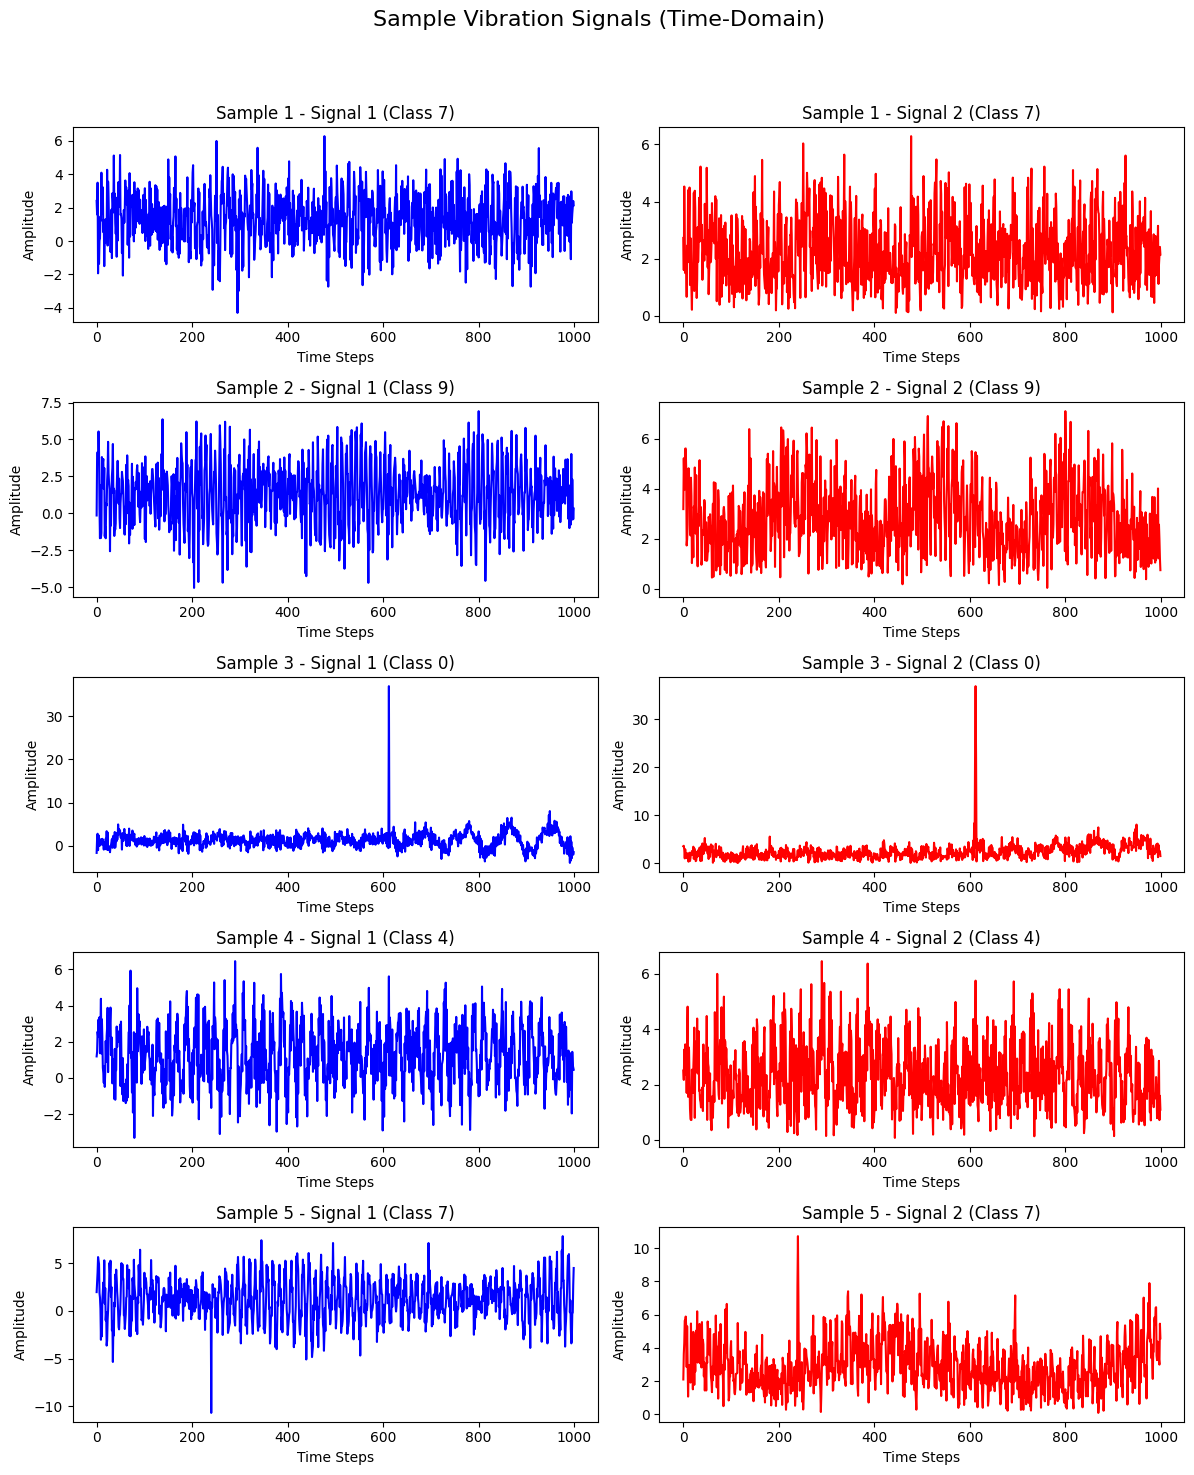

In [112]:
import matplotlib.pyplot as plt

# Plot a few samples from different fault classes
def plot_time_series_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, num_samples * 3))
    fig.suptitle('Sample Vibration Signals (Time-Domain)', fontsize=16)

    for i in range(num_samples):
        sample, label = dataset[i]
        time_steps = np.arange(sample.shape[1])

        axes[i, 0].plot(time_steps, sample[0], label=f'Class {label}', color='b')
        axes[i, 1].plot(time_steps, sample[1], label=f'Class {label}', color='r')

        axes[i, 0].set_title(f'Sample {i+1} - Signal 1 (Class {label})')
        axes[i, 1].set_title(f'Sample {i+1} - Signal 2 (Class {label})')

        axes[i, 0].set_xlabel('Time Steps')
        axes[i, 1].set_xlabel('Time Steps')

        axes[i, 0].set_ylabel('Amplitude')
        axes[i, 1].set_ylabel('Amplitude')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_time_series_samples(train_dataset)

### 2. Visualizing Frequency-Domain (FFT) for a Sample

#### This plot shows the frequency spectrum of the vibration signal. The peaks represent the dominant frequencies in the signal, which can help in understanding the underlying frequency content of the vibration data.

Visualizing FFT for Class 7


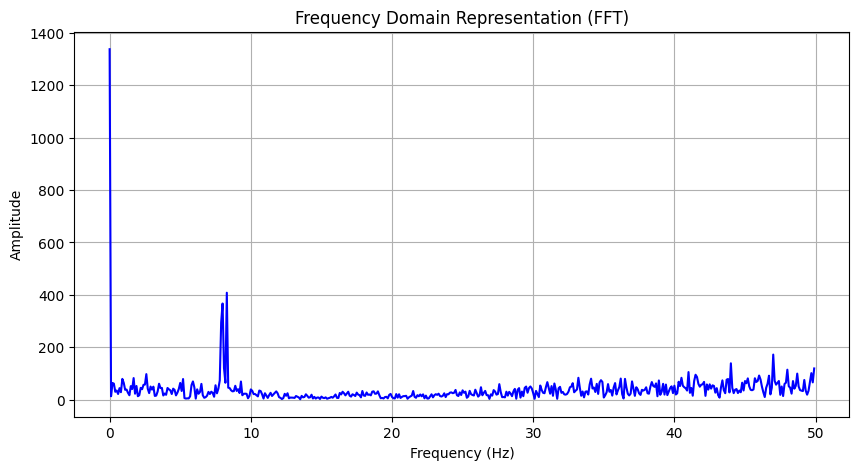

In [113]:
def plot_frequency_domain(signal, sampling_rate=100):
    n = len(signal)
    freq = np.fft.fftfreq(n, d=1./sampling_rate)
    fft_vals = np.abs(np.fft.fft(signal))

    # Plot the FFT result
    plt.figure(figsize=(10, 5))
    plt.plot(freq[:n // 2], fft_vals[:n // 2], color='b')
    plt.title('Frequency Domain Representation (FFT)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# Pick a sample and visualize its FFT
sample, label = train_dataset[0]
print(f"Visualizing FFT for Class {label}")
plot_frequency_domain(sample[0])  # Apply FFT to signal 1 of the sample

### 3. Visualizing Class Distribution

#### The bar chart shows how the samples are distributed across different fault classes. A balanced dataset would have roughly equal numbers of samples per class.

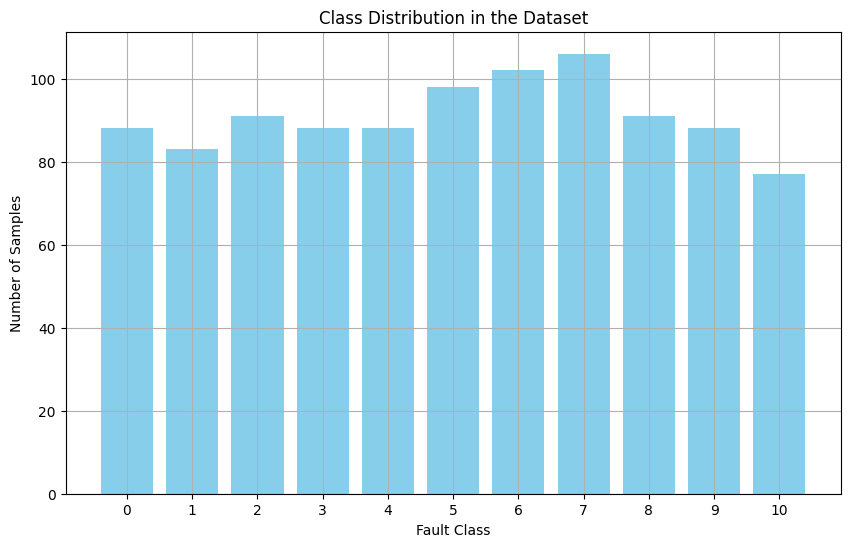

In [114]:
def plot_class_distribution(dataset):
    labels = dataset.labels
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.title('Class Distribution in the Dataset')
    plt.xlabel('Fault Class')
    plt.ylabel('Number of Samples')
    plt.xticks(unique_labels)
    plt.grid(True)
    plt.show()

plot_class_distribution(train_dataset)

### model definition cnn + bidirectional lstm

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FaultDetectionModel(nn.Module):
    def __init__(self, input_shape, num_classes=11):
        super(FaultDetectionModel, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[0], out_channels=64, kernel_size=3, padding=1)  # in_channels=input_shape[0] (e.g., 2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)
        
        # Bidirectional LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=64, batch_first=True, bidirectional=True)
        
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        
        self.dropout_fc = nn.Dropout(0.2)
        
    def attention(self, lstm_output):
        attn_weights = F.softmax(torch.tanh(lstm_output), dim=1)
        attn_applied = torch.mul(lstm_output, attn_weights)
        return attn_applied

    def forward(self, x):
        # CNN block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # LSTM block
        x = x.permute(0, 2, 1)  # Prepare for LSTM (batch_size, time_steps, features)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        # Attention layer
        x = self.attention(x)
        
        # Fully connected block
        x = torch.mean(x, dim=1)  # Global average pooling to collapse time dimension
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout_fc(x)
        
        output = F.log_softmax(self.fc3(x), dim=1)
        
        return output

### model training

Epoch [1/10], Loss: 2.3969, Accuracy: 10.80%
Epoch [2/10], Loss: 2.3933, Accuracy: 10.50%
Epoch [3/10], Loss: 2.3854, Accuracy: 10.70%
Epoch [4/10], Loss: 2.3510, Accuracy: 12.80%
Epoch [5/10], Loss: 2.2557, Accuracy: 18.90%
Epoch [6/10], Loss: 2.0909, Accuracy: 18.90%
Epoch [7/10], Loss: 1.9696, Accuracy: 18.60%
Epoch [8/10], Loss: 1.8610, Accuracy: 23.00%
Epoch [9/10], Loss: 1.8489, Accuracy: 22.40%
Epoch [10/10], Loss: 1.7404, Accuracy: 27.80%


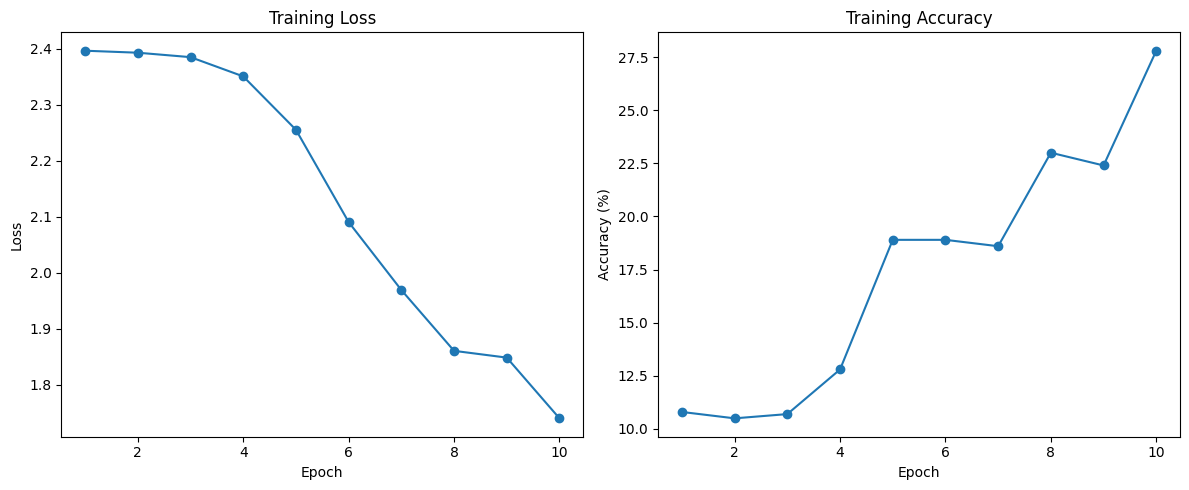

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FaultDetectionModel(input_shape=(2, 1000)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    
    # Lists to store loss and accuracy
    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Calculate running loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate epoch loss and accuracy
        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    # Plot loss and accuracy
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='o')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()

train(model, train_loader, criterion, optimizer, num_epochs=10)


### model evaluation

Test Accuracy: 28.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.25      0.92      0.40        26
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        18
           4       0.25      0.06      0.10        17
           5       0.61      0.82      0.70        17
           6       0.25      0.10      0.14        10
           7       0.25      0.84      0.39        19
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        20
          10       0.00      0.00      0.00        17

    accuracy                           0.28       200
   macro avg       0.15      0.25      0.16       200
weighted avg       0.14      0.28      0.16       200



<Figure size 800x600 with 0 Axes>

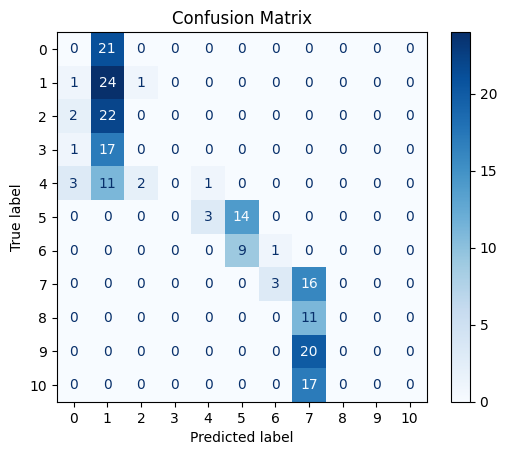

In [120]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def evaluate(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    if not all_labels:
        print("No data in test_loader to evaluate.")
        return

    # Compute accuracy
    total = len(all_labels)
    correct = sum(true == pred for true, pred in zip(all_labels, all_preds))
    accuracy = 100 * correct / total

    print(f'Test Accuracy: {accuracy:.2f}%')

    # Compute and print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, zero_division=0))

    # Compute and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

evaluate(model, test_loader, device)


### make predictions

In [ ]:
import torch
import torch.nn.functional as F

# Define the input shape and model parameters
input_shape = (2, 13)  # (num_channels, sequence_length)
batch_size = 1  # Single sample for testing

sample_input = torch.randn(batch_size, *input_shape)

num_classes = 11  # Number of output classes
model = FaultDetectionModel(input_shape=input_shape, num_classes=num_classes)

model.eval()

# Perform a forward pass through the model
with torch.no_grad():  
    output = model(sample_input)

# Convert log probabilities to probabilities
probabilities = torch.exp(output)

# Find the predicted class by getting the index of the highest probability
_, predicted_class = torch.max(probabilities, dim=1)

print("Model output (log probabilities):", output)
print("Probabilities:", probabilities)
print("Predicted class index:", predicted_class.item())